This notebook attempts to perform Spearman Correlation Analysis between EEG electrode signals. This notebook makes some assumptions about the data:

1. All EEG data is collected with the [*Mind Monitor*](https://mind-monitor.com/) mobile application using a [*Muse 2*](https://choosemuse.com/products/muse-2) or [*Muse S*](https://choosemuse.com/products/muse-s-gen-2) headband.
2. All user data is contained in a relative `./data/` directory. Within it contains the following files/directories:
    1. `participants.csv`: From users' demographic survey data.
    2. `trials_aligned/`: subdirectory containing all trial data. Within this subdirectory:
        1. All participants are sorted into folders of `p1`, `p2`, etc.
        2. Within each participant directory, trials are named as "jay-vr-<#>" (ex. `jay-vr-2`). Each trial will have some path similar to `p#/jay-vr-#/`.
        3. Each trial directory must contain:
            1. `pedestrians-aligned.csv`: agent trajectory data from the VR session. Does NOT contain the participant's trajectory data. Aligned to match the timestamps from trial data and EEG data.
            2. `raw_eeg.csv`: the raw EEG data collected from [*Mind Monitor*](https://mind-monitor.com/).
            3. `trial.csv`: the trial timestamps from the VR session.
            4. `user-aligned.csv`: the user's trajectory data from the VR session. Algined to match the timestamps from trial data and EEG data.
        
Based on findings from `participant_filtering.ipynb`, these participant trials will be used:

* P1: Trial(s) 2
* P2: Trial(s) 1,4
* P6: Trial(s) 1,2
* P7: Trial(s) 1,2
* P8: Trial(s) 3
* P9: Trial(s) 1,2
* P10: Trial(s) 3
* P11: Trial(s) 1,2,3
* P12: Trial(s) 2,3
* P14: Trial(s) 1,2,3
* P15: Trial(s) 2,3
* P16: Trial(s) 1,2,3,4
* P17: Trial(s) 1,2,3
* P18: Trial(s) 1,2,3

# 0. Import Packages, Global Variables

In [4]:
# Imports
import os
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import entropy, kendalltau, pearsonr, spearmanr
from scipy import spatial
from scipy.spatial.distance import directed_hausdorff
import random 
import datetime

# Helpers
from helpers import timestamp_to_unix_seconds as unix_seconds # Timestamps to Unix Seconds
from helpers import timestamp_to_unix_milliseconds as unix_milliseconds # Timestamps to Unix Milliseconds
from helpers import get_immediate_subdirectories
from helpers import get_immediate_files
from helpers import process_raw_eeg

# Settings
pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
"""  ___________________________________  """
""" |TO-DOs:                            | """
""" | - Set the relative path data      | """
""" | - Change frequencies of ineterest | """
""" | - Change electrodes of ineterest  | """
""" | - Change which trials to use      | """
"""   ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅  """
_DATA_DIR = './data/'
_FREQUENCY_BANDS = ['Delta','Theta','Alpha','Beta','Gamma']
_ELECTRODES = ['AF7','AF8']   # Note that we removed `TP9` and `TP10` from analysis
_FREQUENCY_COLORS = ['gray', 'red', 'blue', 'green', 'orange']
_ACCEPTED_PARTICIPANTS = {
    'p1':['jay-vr-2'],
    'p2':['jay-vr-1','jay-vr-4'],
    'p6':['jay-vr-1','jay-vr-2'],
    'p7':['jay-vr-1','jay-vr-2'],
    'p8':['jay-vr-3'],
    'p9':['jay-vr-1','jay-vr-2'],
    'p10':['jay-vr-3'],
    'p11':['jay-vr-1','jay-vr-2','jay-vr-3'],
    'p12':['jay-vr-2','jay-vr-3'],
    'p14':['jay-vr-1','jay-vr-2','jay-vr-3'],
    'p15':['jay-vr-2','jay-vr-3'],
    'p16':['jay-vr-1','jay-vr-2','jay-vr-3','jay-vr-4'],
    'p17':['jay-vr-1','jay-vr-2','jay-vr-3'],
    'p18':['jay-vr-1','jay-vr-2','jay-vr-3']
}

# Data Paths - Automated!
_DEMOGRAPHICS_FILE = os.path.join(_DATA_DIR, 'participants.csv')
_RESTCONC_DIR = os.path.join(_DATA_DIR, 'rest_conc_data/')
_ALIGNED_DIR = os.path.join(_DATA_DIR, 'trials_aligned/')

# Output directory based on restconc directory. Double-check that it exists
_OUTPUT_DIR = os.path.join(_ALIGNED_DIR, f'outputs_correlations_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}/')
try: os.makedirs(_OUTPUT_DIR)
except OSError as e:
    if e.errno != errno.EEXIST: raise  # This was not a "directory exist" error..

# Extraneous columns in EEG. No need to modify unless necessary
_EXTRA_EEG_COLUMNS = [
    'Accelerometer_X','Accelerometer_Y','Accelerometer_Z',
    'Gyro_X','Gyro_Y','Gyro_Z',
    'HeadBandOn','Battery','Elements',
    'HSI_AF7','HSI_AF8',
    'HSI_TP9','HSI_TP10'
]

# 1. Reading Rest EEGs

In [6]:
rest_dfs = []

# Get the restconc filenames
restconc_files = get_immediate_files(_RESTCONC_DIR)

# Filter through each file to extract their details.
for fname in restconc_files:
    # Filter - make sure it's a CSV file
    filename, file_extension = os.path.splitext(fname)
    if file_extension != '.csv':
        # print("\tSKIPPING - of type {file_extension}, not .csv")
        continue
    
    # Parse the filename into segments, delimiter = '-'
    #   names must be split into 3 segments: participant-task-tasktype
    segments = filename.split('-')
    if len(segments)!=3:
        # print(f"\tERROR: Cannot parse {fname} - properly incorrectly named")
        continue
    
    # Check if participant is in dict. of accepted participants
    if segments[0] not in _ACCEPTED_PARTICIPANTS:
        continue
    
    # We only need rest vr
    if segments[1] != 'rest' or segments[2] != 'vr':
        continue
        
    # Read rest EEG
    rest_df = process_raw_eeg(os.path.join(_RESTCONC_DIR, fname))    
    rest_df['rel_unix_ms'] = rest_df['unix_ms'] - rest_df['unix_ms'].iloc[0]
    rest_df = rest_df[rest_df['rel_unix_ms'].between(5000, rest_df['rel_unix_ms'].iloc[-1]-5000)]
    rest_df.drop(columns=_EXTRA_EEG_COLUMNS, inplace=True)
    rest_df = rest_df.loc[:,~rest_df.columns.str.contains('TP', case=False)]
    rest_ranges = rest_df.agg(['min', 'max'])
    rest_ranges['participant'] = segments[0]

    # Add rest range to rest_dfs
    rest_dfs.append(rest_ranges)

# Concatenate rest eegs
gr_df = pd.concat(rest_dfs, ignore_index=False)
display(gr_df)

# To identify a min or max of a specific band-electrode combo, use the following:
# gr_df[gr_df['participant']=='<p#>'].loc['<min/max>','<frequency band>_<electrode>']

,AUX_RIGHT,AUX_LEFT,unix_ms,Delta_AF7,Delta_AF8,Theta_AF7,Theta_AF8,Alpha_AF7,Alpha_AF8,Beta_AF7,Beta_AF8,Gamma_AF7,Gamma_AF8,rel_unix_ms,participant
min,731.318681,568.131868,1736096352378,0.797434,0.408052,0.225614,0.261056,0.609788,0.499961,0.509854,0.460017,0.322052,0.166865,5026,p18
max,971.062271,1011.758242,1736096388342,5.121863,3.481967,1.638826,1.722656,2.273676,3.437659,1.429302,1.242855,0.780932,0.414207,40990,p18
min,596.336996,NaN,1732467703445,0.319759,0.381304,0.279555,0.365124,0.752367,0.564250,0.516732,0.449140,0.202410,0.193891,5000,p11
max,1003.699634,NaN,1732467736945,11.996098,21.848154,2.900980,3.263016,3.844500,3.306106,1.238689,1.113273,0.640626,0.828365,38500,p11
min,653.553114,NaN,1732119787381,1.551004,1.215931,0.931482,0.890315,1.199342,1.641615,0.991115,1.094797,0.334598,0.330013,5009,p9
max,882.820513,NaN,1732119815371,8.119381,12.061831,3.560303,4.828981,4.628021,8.285715,2.221942,1.975343,0.831973,0.780775,32999,p9
min,597.142857,NaN,1733085257478,0.234898,0.335209,0.211639,0.203881,0.542984,0.475970,0.466714,0.419752,0.179662,0.156882,5001,p14
max,1074.212454,NaN,1733085290978,1.952388,3.868659,0.971672,1.054366,1.961310,1.464607,0.969282,0.916735,0.416815,0.345777,38501,p14
min,644.688645,NaN,1730739917372,0.446767,0.691551,0.364585,0.275130,0.574526,0.602259,0.415078,0.462003,0.211973,0.220425,5000,p6
max,940.842491,NaN,1730739949371,3.143868,4.885736,1.354098,1.564790,2.495630,2.122224,0.892879,0.920728,0.377295,0.627766,36999,p6


# 2. Reading Trial Data

We will perform correlation tests on EEG powers to the following properties:

- **Crowd Entropy** - generalizing the overall chaos in that moment. Bidirectional flows will produce less entropy than one where there's no discernable bidirectional flow.
- **Velocity Alignment** - Weighted estimation of how "aligned" the participant's movement is relative to others. Closer pedestrains will have a stronger effect on this than further-away ones.
- **Forward Velocity Disruption** - when a person has to divert away from their current forward traject, we track these via a one-hot encoding: during redirection and while stable. Encapsulated by deriv. of acceleration alternations across 0. Considering the fluctuating nature, we will have to group instances when the change across the 0 axis reaches a certain value - i.e. 1 SD above or below the mean.
- **Forward Velocity** - Of course, we also just form a basic correlation between forward velocity and eeg power.
- **Number of Neighbors** - Will more people affect EEG? Consider within a neighborhood of a certain radius.
- **Closest Neighbor Distance** - Will the proximity of other people affect EEG power? This one is just a pure distance metric.

## 2.1 Functions

In [7]:
def GetDirectionBin(deg_angle, discretization_angle=45):
    # angles given by math.degrees are -180 (left, bottom) to 180 (left, top).
    # Add 180 to simplify the operation
    angle = deg_angle + 180
    # Divide by some discretization factor.
    bin_number = math.floor(angle/discretization_angle)
    return bin_number

def CalculateNeighborStatistics(row, agents_df, distance_threshold:float=5.0):
    # Initiate a return dictionary
    return_dict = {}
    
    # Get the agents at the same timestamp. Trial milliseconds should be aligned here.
    agents_at_timestamp = agents_df[(agents_df['trial_ms']==row['trial_ms']) & (agents_df['is_active']==1)]
    
    # Get the neighbor agents within a distance threshold, get neighbor count
    neighbor_agents = agents_at_timestamp[agents_at_timestamp['distance_from_participant']<=distance_threshold]
    return_dict['neighbor_count'] = len(neighbor_agents.index)
    
    # End early if we don't have any neighbors. We have some default values to place.
    if return_dict['neighbor_count'] == 0:
        return_dict['min_distance'] = 5.0
        return_dict['entropy'] = 0.0
        return_dict['vel_diff'] = 0.0
        return return_dict
        
    # Calculate the minimum distance between the pedestrian and the closest pedestrian
    return_dict['min_distance'] = neighbor_agents['distance_from_participant'].min()
    
    # Calculate shannon entropy by direction (AKA angle relative to +x)
    agents = pd.concat([pd.DataFrame([row]), neighbor_agents], ignore_index=True)
    agents['direction'] = agents.apply(lambda row: math.degrees(math.atan2(row['velocity_z'], row['velocity_x'])), axis=1)
    agents['bin'] = agents['direction'].apply(lambda x: GetDirectionBin(x, discretization_angle=30))
    return_dict['entropy'] = entropy(agents['bin'].value_counts())
    
    # Calculate velocity difference
    neighbor_agents['weighted_velocity_x'] = (row['velocity_x'] - neighbor_agents['velocity_x']) * ((distance_threshold-neighbor_agents['distance_from_participant'])/distance_threshold)
    neighbor_agents['weighted_velocity_z'] = (row['velocity_z'] - neighbor_agents['velocity_z']) * ((distance_threshold-neighbor_agents['distance_from_participant'])/distance_threshold)
    neighbor_agents['weighted_velocity_diff'] = np.sqrt(neighbor_agents['weighted_velocity_x']**2 + neighbor_agents['weighted_velocity_z']**2)
    return_dict['vel_diff'] = neighbor_agents['weighted_velocity_diff'].mean()
    
    # Return 
    return return_dict

# `val_cols` must be a dictionary whose keys = columns and values = methods ('min','max','mean','sd')
def Downsample(df, ms_col, val_cols, window_ms=500, slide_ms=250, include_dt:bool=False):
    # Initialize an empty list to store downsampled results
    downsampled_data = []
    
    # Sort rows to make sure they are in time order
    df2 = df.sort_values(ms_col)
    
    # Start sliding the window
    start_time = df2[ms_col].min()

    while start_time + window_ms <= df2[ms_col].max():
        # Get the subset of data in the current window
        end_time = start_time + window_ms
        window_data = df2[(df2[ms_col] >= start_time) & (df2[ms_col] < end_time)]
        
        if not window_data.empty:
            downsampled_row = {
                f'{ms_col}_start': start_time,
                f'{ms_col}_end': end_time,
                'num_entries':len(window_data.index)
            }
            if include_dt:
                downsampled_row['dt'] = window_data['dt'].sum()
            for col in val_cols:
                method = val_cols[col]
                if method == 'max':
                    downsampled_row[col] = window_data[col].max()
                elif method == 'min':
                    downsampled_row[col] = window_data[col].min()
                elif method == 'sd':
                    downsampled_row[col] = window_data[col].std()
                else:
                    downsampled_row[col] = window_data[col].mean()
            downsampled_data.append(downsampled_row)

        # Slide the window
        start_time += slide_ms

    # Convert the downsampled data into a DataFrame
    downsampled_df = pd.DataFrame(downsampled_data)
    return downsampled_df

def EEGWindows(row, eeg_df, frequencies, electrodes, method='mean'):
    # Initialize return dict
    return_dict = {}
    
    # For each freq_band column name, get the prior, during, and after windows
    during_df = eeg_df[eeg_df['trial_ms'].between(row['trial_ms_start'], row['trial_ms_end'])]
    
    for freq in frequencies:
        for elec in electrodes:
            col = f'{freq}_{elec}'
            if method == 'sd':
                return_dict[col] = during_df[f'{col}_normalized'].std()
            else:
                return_dict[col] = during_df[f'{col}_normalized'].mean()
    
    # Return resulting dictionary
    return return_dict

def CalculateHausdorff(window_row, user_df, agents_df, distance_threshold=5.0):
    agents_in_window = agents_df[agents_df['trial_ms'].between(window_row['trial_ms_start'], window_row['trial_ms_end'])]
    agents_in_range = agents_in_window[agents_in_window['distance_from_participant']<=distance_threshold]
    
    # weird case: no agents in range. We then just return 0.0
    if len(agents_in_range.index) == 0:
        return 0
    
    # Get the tuple positions of the participant in this window
    user_rows = user_df[user_df['trial_ms'].between(window_row['trial_ms_start'], window_row['trial_ms_end'])]
    user_trajectory = list(zip(user_rows['pos_x'], user_rows['pos_z']))
        
    # For each unique agent, as long as they were in range at some point, we consider them.
    unique_agents = agents_in_range['id'].tolist()
    hauses = []
    for aid in unique_agents:
        agent_rows = agents_in_window[agents_in_window['id']==aid]
        agent_trajectory = list(zip(agent_rows['pos_x'], agent_rows['pos_z']))
        # hausdorff
        haus = directed_hausdorff(user_trajectory, agent_trajectory)
        hauses.append(haus[0])
    
    # Calculate the average haus distance
    avg_haus = np.mean(hauses)
    return avg_haus

def densityF(x, y, t, xi, yi, ti, ct1, ct2, xyBand, tBand):
    u = (x-xi) / xyBand 
    v = (y-yi) / xyBand 
    w = (t-ti) / tBand 
    Ks = ct1 * (1 - pow(u, 2) - pow(v, 2))
    Kt = 0.75 * (1 - pow(w, 2))
    spaceTimeKDE = ct2 * Ks * Kt
    return spaceTimeKDE

# Only look at neighbors. We don't use the participants themselves
def STKDE(
        agents_df, 
        xMin=-2.5, xMax=2.5, yMin=-2.5, yMax=2.5,
        xyBand=1, xyRes=0.5, tBand=200, tRes=100 ):
    # xyBand = bandwidth, controls how spread out the distribution will be. If set to a high value, the overall distribution will be flatter.
    # xyRes = resolution, controls how fine-grained we grid-ify our space
    # tRes = at what time intervals do we discretize our data.
    # Agents_df already should have rel_pos_x/y/z and trial_ms. We'll use that to our advantage.
    
    # Calculate spatial properties related to space-time kernel estimation
    xMinDiff = xMin % xyRes
    xMaxDiff = xMax % xyRes
    yMinDiff = yMin % xyRes
    yMaxDiff = yMax % xyRes
    xMinP = xMin - xMinDiff + xyRes
    xMaxP = xMax - xMaxDiff + xyRes
    yMinP = yMin - yMinDiff + xyRes
    yMaxP = yMax - yMaxDiff + xyRes
    
    # Calculate temporal resolutions related to estimation. Relies on the last known trial-ms column
    zMin = 0.0
    zMax = agents_df['trial_ms'].iloc[-1]
    zMinDiff = zMin % tRes
    zMaxDiff = zMax % tRes
    zMinP = zMin - zMinDiff + tRes
    zMaxP = zMax - zMaxDiff + tRes
    
    # Calculate the grids
    xyGrid = []
    for i in np.arange(int(xMinP), int(xMaxP), xyRes):
        for j in np.arange(int(yMinP),int(yMaxP), xyRes):
            xyGrid.append([i,j])
    tGrid = []
    for k in range(int(zMinP),int(zMaxP), tRes):
        tGrid.append([k])
        
    # Extract XY of agents. We'll isolate to just active agents, and use their relative positions.
    active_agents = agents_df[agents_df['is_active']==1]
    inX = active_agents['rel_pos_x'].tolist()
    inY = active_agents['rel_pos_z'].tolist()
    inT = active_agents['trial_ms'].tolist()
    n = len(inX)
    inT= [[t] for t in inT]
    inXY = list(zip(inX, inY))
    ct1 = 0.5 * math.pi
    ct2 = pow(10.0, 5) / (n * pow(xyBand, 2) * tBand)
    
    # form necessary trees
    stree = spatial.cKDTree(inXY)
    ttree = spatial.cKDTree(inT)
    
    # Using trees:
    sList = stree.query_ball_point(xyGrid, xyBand)
    tList = ttree.query_ball_point(tGrid, tBand)
    
    # Output densities
    stList = []
    i = 0
    while i < len(sList): #loop though list of spatial neighbors (there is a list of neighbors for each xyGrid-point)
        j = 0
        while j < len(tList): #loop through list of temporal neighbors (there is a list of neighbors for each tGrid-point)
            nList = [val for val in sList[i] if val in tList[j]]	#check for points that are neighbors spatially, as well as temporally
            xC, yC, zC = xyGrid[i][0], xyGrid[i][1], tGrid[j]		#fetch grid point
            density = 0.0
            if nList:
                for k in nList:
                    nindex = int(k)
                    density += densityF(inXY[nindex][0], inXY[nindex][1], inT[nindex][0], xC, yC, zC[0], ct1, ct2, xyBand, tBand)
                #stkdeFile.write(str(xC) + "," + str(yC) + "," + str(zC[0]) + "," + str(density) +"\n")
                stList.append({'xC':xC, 'yC':yC, 'tC':zC[0],'density':density})
            j = j + 1
        i = i + 1
    
    # display
    st_df = pd.DataFrame(stList)
    return st_df

def CalculateSTKDE(window_row, stkde_df, method):
    # Get only entries within the time window.
    stkde_entries = stkde_df[stkde_df['tC'].between(window_row['trial_ms_start'], window_row['trial_ms_end'])]
    
    # Isolate to only entries where `xC` and `yC` are between a range. Note that `xC` and `yC` are upper bounds,
    # so we'll want `xC` to be between (inclusive) 0 and 0.5, for example, which should capture areas around -0.5 to 0.5.
    # We can then just mean them.
    stkde_inrange = stkde_entries[(stkde_entries['xC'].between(0.0, 0.5, inclusive='both')) & (stkde_entries['yC'].between(0.0, 0.5, inclusive='both'))]
    stkde_agg = stkde_inrange.groupby('tC').agg(
        t=('tC', 'first'),
        density = ('density','mean')
    )    
    
    # Depending on the method, we'll have to choose between mean or standard deviation
    # Note that `stkde_agg` still has different rows depending on `tC`.
    if method == 'sd':
        return stkde_agg['density'].std()
    else:
        return stkde_agg['density'].mean()
    

## 2.2 Aggregation

In [9]:
samples_means = []
#samples_sds = []

# Get the aligned filenames, filter based on accepted trials
aligned_files = [pdir for pdir in get_immediate_subdirectories(_ALIGNED_DIR) if pdir in _ACCEPTED_PARTICIPANTS]

# Loop through accepted participants
for pid in aligned_files:
    
    # Find all subdirectories in each participant
    pdir = os.path.join(_ALIGNED_DIR,pid)
    ptrials = [t for t in get_immediate_subdirectories(pdir) if t in _ACCEPTED_PARTICIPANTS[pid]]
    
    # For each trial:
    for t in ptrials:
        
        # Each trial directory must contain the following:
        # - raw_eeg.csv
        # - trial.csv
        # - user-aligned.csv
        # - pedestrians-aligned.csv
        
        # Get trial directory
        tdir = os.path.join(pdir, t)
        
        # Read the trial data
        trial_df = pd.read_csv(os.path.join(tdir, 'trial.csv'))
        start_unix_ms = trial_df.iloc[-1]['unix_ms']
        
        # Read the EEG data
        eeg_raw_df = process_raw_eeg(os.path.join(tdir,'raw_eeg.csv'))
        # Restrict trial data between start and end timestamps
        end_unix_ms = eeg_raw_df['unix_ms'].iloc[-1] - 5000
        eeg_df = eeg_raw_df[eeg_raw_df['unix_ms'].between(start_unix_ms, end_unix_ms)]
        # Calculate trial metrics
        eeg_df['trial_ms'] = eeg_df['unix_ms'] - start_unix_ms
        # Drop columns
        eeg_df = eeg_df.drop(columns=_EXTRA_EEG_COLUMNS)
        eeg_df = eeg_df.loc[:,~eeg_df.columns.str.contains('TP', case=False)]
        # Get the last trial milliseconds
        eeg_end_ms = eeg_df.iloc[-1]['trial_ms']
        
        # EEG Data Normalization
        for freq in _FREQUENCY_BANDS:
            for electrode in _ELECTRODES:
                in_colname = f'{freq}_{electrode}'
                out_colname = f'{in_colname}_normalized'
                minValue = gr_df[gr_df['participant']==pid].loc['min', in_colname]
                maxValue = gr_df[gr_df['participant']==pid].loc['max', in_colname]
                eeg_df[out_colname] = (eeg_df[in_colname] - minValue) / (maxValue - minValue)    
        
        # Read position data of other agents. The data should already be aligned to match the trial data
        agents_df = pd.read_csv(os.path.join(tdir, 'pedestrians-aligned.csv'))
        agents_df = agents_df.drop(columns=['pos_y','rel_pos_y','forward_y','rel_forward_y','velocity_y','rel_velocity_y'])
        agents_df = agents_df.rename(columns={'trial_milliseconds': 'trial_ms'})
        # Check if a pedestrian is visible within 110 degrees along the horizon, or 55 degrees on either side
        agents_df['in_fustrum'] = abs(agents_df['angle_from_participant']) <= 55
        agents_kde = STKDE(agents_df)

        # Read position data of the participant. The data should already be aligned to match the trial data
        user_df = pd.read_csv(os.path.join(tdir, 'user-aligned.csv'))
        user_df = user_df.groupby(['pos_x','pos_y','pos_z'],as_index=False).first().sort_values(by=['trial_milliseconds'])
        user_df = user_df.drop(columns=['pos_y','rel_pos_y','forward_y','rel_forward_y','velocity_y','rel_velocity_y'])
        user_df = user_df.rename(columns={'trial_milliseconds': 'trial_ms'})
        # Delta time here is always in seconds
        user_df['trial_sec'] = user_df['trial_ms'] / 1000;
        user_df['dt'] = user_df['trial_sec'].diff().fillna(0)
        user_df = user_df[user_df['trial_ms'] <= eeg_end_ms]
        
        # Calculate minimum distance, entropy, vel_diff, 
        neighbor_calculations = user_df.apply(lambda row: CalculateNeighborStatistics(row, agents_df), axis='columns', result_type='expand')
        player_df = pd.concat([user_df, neighbor_calculations], axis='columns')

        # Formulate 250ms windows, sliding by 250ms. This is to prevent overlap between events + aggregate sample windows
        player_samples_mean = Downsample(player_df, ms_col='trial_ms', val_cols={
            'min_distance':'mean',
            'neighbor_count':'mean',
            'entropy':'mean',
            'vel_diff':'mean',
        }, include_dt=True, window_ms=2000,slide_ms=2000)
        #player_samples_sd = Downsample(player_df, ms_col='trial_ms', val_cols={
        #    'min_distance':'sd',
        #    'neighbor_count':'sd',
        #    'entropy':'sd',
        #    'vel_diff':'sd',
        #}, include_dt=True, window_ms=2000,slide_ms=2000)
        
        # We must also use the same windows to calculate the hausdorff distance for the trajectories in each window
        # In this case, we'll just use pairwise hausdorff for other pedestrian and average across all pedestrians
        # If there are no neighbors in this window, then we set as 0.
        # Note that each row here is a window of time
        player_samples_mean['hausdorff'] = player_samples_mean.apply(lambda row: CalculateHausdorff(row, user_df, agents_df), axis=1)
        
        # Let's also calculate the kernel density estimation around the participants, averaged out.
        player_samples_mean['stkde'] = player_samples_mean.apply(lambda row: CalculateSTKDE(row, agents_kde, method='mean'), axis=1)
        
        # Now we must combine eeg and player data, within sliding windows. This is equivalent of downsampling.
        # For the sake of equivalency with our other paper, we'll apply a window size of 2sec (2000ms) both prior and after
        player_eeg_mean = player_samples_mean.apply(lambda row: EEGWindows(row, eeg_df, _FREQUENCY_BANDS, _ELECTRODES, method='mean'), axis=1, result_type='expand')
        
        # Combine and concatenate the disparate dataframes
        sample_eegs_mean = pd.concat([player_samples_mean, player_eeg_mean], axis='columns')
        sample_eegs_mean = sample_eegs_mean.dropna()
        sample_eegs_mean['participant'] = pid
        sample_eegs_mean['trial_id'] = t
        
        # Finally, add samples to total dfs
        samples_means.append(sample_eegs_mean)
        print(pid, '\t', t, '\tDONE!')
        
# Now, combine into a global sample df
gsamples_df = pd.concat(samples_means, ignore_index=True)

display(gsamples_df)

p2 	 jay-vr-4 	DONE!
p2 	 jay-vr-1 	DONE!
p17 	 jay-vr-2 	DONE!
p17 	 jay-vr-3 	DONE!
p17 	 jay-vr-1 	DONE!
p10 	 jay-vr-3 	DONE!
p11 	 jay-vr-2 	DONE!
p11 	 jay-vr-3 	DONE!
p11 	 jay-vr-1 	DONE!
p16 	 jay-vr-2 	DONE!
p16 	 jay-vr-3 	DONE!
p16 	 jay-vr-4 	DONE!
p16 	 jay-vr-1 	DONE!
p18 	 jay-vr-2 	DONE!
p18 	 jay-vr-3 	DONE!
p18 	 jay-vr-1 	DONE!
p7 	 jay-vr-2 	DONE!
p7 	 jay-vr-1 	DONE!
p9 	 jay-vr-2 	DONE!
p9 	 jay-vr-1 	DONE!
p8 	 jay-vr-3 	DONE!
p6 	 jay-vr-2 	DONE!
p6 	 jay-vr-1 	DONE!
p1 	 jay-vr-2 	DONE!
p14 	 jay-vr-2 	DONE!
p14 	 jay-vr-3 	DONE!
p14 	 jay-vr-1 	DONE!
p15 	 jay-vr-2 	DONE!
p15 	 jay-vr-3 	DONE!
p12 	 jay-vr-2 	DONE!
p12 	 jay-vr-3 	DONE!


,trial_ms_start,trial_ms_end,num_entries,dt,min_distance,neighbor_count,entropy,vel_diff,hausdorff,stkde,...,Theta_AF7,Theta_AF8,Alpha_AF7,Alpha_AF8,Beta_AF7,Beta_AF8,Gamma_AF7,Gamma_AF8,participant,trial_id
0,29,2029,49,1.996,0.660680,2.000000,0.636514,0.865639,35.829745,0.055034,...,0.349485,0.077553,0.875899,0.150750,1.845434,0.014108,0.592946,0.104245,p2,jay-vr-4
1,2029,4029,48,2.002,0.929774,2.000000,0.636514,2.177921,36.451899,0.062198,...,0.405090,-0.061820,0.611328,-0.115712,1.629301,0.063219,0.416311,0.069193,p2,jay-vr-4
2,18029,20029,48,1.999,2.102713,1.000000,0.693147,2.541227,42.810668,0.037069,...,1.193472,1.650427,0.937802,1.075803,1.801056,-0.020663,0.501762,-0.054776,p2,jay-vr-4
3,20029,22029,48,2.001,2.832110,0.979167,0.678707,2.005044,42.909803,0.033671,...,1.860698,1.049759,1.276488,0.539838,1.744764,-0.056774,0.496979,-0.096679,p2,jay-vr-4
4,24029,26029,48,2.002,1.617551,2.916667,0.945810,2.265333,38.356493,0.046120,...,0.772295,0.324651,0.667946,0.571295,1.956406,-0.112692,0.401961,0.008651,p2,jay-vr-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,16018,18018,63,1.976,1.225104,3.460317,1.011834,2.113646,37.740213,0.028421,...,0.477726,0.380456,1.726744,0.437548,2.133708,2.090258,5.927817,2.539408,p12,jay-vr-3
351,18018,20018,70,2.034,1.804712,2.500000,0.774992,1.695184,39.622406,0.050223,...,2.528782,0.199904,3.970962,0.351306,1.719180,0.806132,4.007034,1.510518,p12,jay-vr-3
352,20018,22018,70,1.989,1.204647,2.100000,0.635698,2.261768,40.161060,0.040379,...,1.817863,3.774659,2.952243,2.335548,1.438439,2.694727,5.434842,6.253327,p12,jay-vr-3
353,22018,24018,70,1.998,1.571494,2.257143,0.624041,1.701007,39.873262,0.038785,...,1.484033,1.318126,2.568218,0.945018,0.759589,1.725791,1.760327,2.523104,p12,jay-vr-3


In [10]:
# Output the `gsamples` dataframe into a csv file for later.
gsample_savefile = os.path.join(_OUTPUT_DIR, 'gsamples.csv')
gsamples_df.to_csv(gsample_savefile, index=False)

# 3. Correlations

## 3.0 Importing `gsamples`

_If you decided to leave after completing the steps above and then want to load in samples again withouth having to run the code yourself, then you can manually load in `gsamples_df` via a cached saved dataframe file._

In [11]:
if gsamples_df is None:
    gsamples_infile = './data/trials_aligned/outputs_correlations_2025-04-15_16-09-55/gsamples.csv'
    print("Reading gsamples file from cache:", gsamples_infile)
    gsamples_df = pd.read_csv(gsamples_infile)
display(gsamples_df)

,trial_ms_start,trial_ms_end,num_entries,dt,min_distance,neighbor_count,entropy,vel_diff,hausdorff,stkde,...,Theta_AF7,Theta_AF8,Alpha_AF7,Alpha_AF8,Beta_AF7,Beta_AF8,Gamma_AF7,Gamma_AF8,participant,trial_id
0,29,2029,49,1.996,0.660680,2.000000,0.636514,0.865639,35.829745,0.055034,...,0.349485,0.077553,0.875899,0.150750,1.845434,0.014108,0.592946,0.104245,p2,jay-vr-4
1,2029,4029,48,2.002,0.929774,2.000000,0.636514,2.177921,36.451899,0.062198,...,0.405090,-0.061820,0.611328,-0.115712,1.629301,0.063219,0.416311,0.069193,p2,jay-vr-4
2,18029,20029,48,1.999,2.102713,1.000000,0.693147,2.541227,42.810668,0.037069,...,1.193472,1.650427,0.937802,1.075803,1.801056,-0.020663,0.501762,-0.054776,p2,jay-vr-4
3,20029,22029,48,2.001,2.832110,0.979167,0.678707,2.005044,42.909803,0.033671,...,1.860698,1.049759,1.276488,0.539838,1.744764,-0.056774,0.496979,-0.096679,p2,jay-vr-4
4,24029,26029,48,2.002,1.617551,2.916667,0.945810,2.265333,38.356493,0.046120,...,0.772295,0.324651,0.667946,0.571295,1.956406,-0.112692,0.401961,0.008651,p2,jay-vr-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,16018,18018,63,1.976,1.225104,3.460317,1.011834,2.113646,37.740213,0.028421,...,0.477726,0.380456,1.726744,0.437548,2.133708,2.090258,5.927817,2.539408,p12,jay-vr-3
351,18018,20018,70,2.034,1.804712,2.500000,0.774992,1.695184,39.622406,0.050223,...,2.528782,0.199904,3.970962,0.351306,1.719180,0.806132,4.007034,1.510518,p12,jay-vr-3
352,20018,22018,70,1.989,1.204647,2.100000,0.635698,2.261768,40.161060,0.040379,...,1.817863,3.774659,2.952243,2.335548,1.438439,2.694727,5.434842,6.253327,p12,jay-vr-3
353,22018,24018,70,1.998,1.571494,2.257143,0.624041,1.701007,39.873262,0.038785,...,1.484033,1.318126,2.568218,0.945018,0.759589,1.725791,1.760327,2.523104,p12,jay-vr-3


## 3.1 Functions

_While we are surely using Spearman, we can technically use different correlation statistics._

In [12]:
def MultipleCorrelations(df, method='kendall', drop_cols=None, rename_cols=None, display_df:bool=True):

    def kendall_pval(x,y):
        return kendalltau(x,y)[1]
    def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]
    
    if method =='pearson': 
        corr_stat = 'pearson'
        corr_pval = pearsonr_pval
    elif method =='spearman': 
        corr_stat = 'spearman'
        corr_pval = spearmanr_pval
    else:
        corr_stat = 'kendall'
        corr_pval = kendall_pval
    
    # Calculate statistics and pvalues
    statistics = df.corr(method=corr_stat, numeric_only=True)
    pvalues = df.corr(method=corr_pval, numeric_only=True) - np.eye(len(df.select_dtypes(include=np.number).columns))
    
    # We drop columns if dictated to
    if drop_cols is not None:
        statistics = statistics.drop(columns=drop_cols, index=drop_cols)
        pvalues = pvalues.drop(columns=drop_cols, index=drop_cols)
    
    # We rename columns if dicated to
    if rename_cols is not None:
        statistics = statistics.rename(columns=rename_cols, index=rename_cols)
        pvalues = pvalues.rename(columns=rename_cols, index=rename_cols)
    
    # Display if needed, and return
    if display_df:
        display(statistics)
        display(pvalues)
    return statistics, pvalues

_CORR_DROP_COLUMNS = [
    'trial_ms_start',
    'trial_ms_end',
    'num_entries',
    'dt'
]
_CORR_RENAME_COLUMNS = {
    'min_distance':'Min\nDistance',
    'neighbor_count':'Num\nNeighbors',
    'vel_diff':'Velocity\nDiff.',
    'entropy':'Shannon\nEntropy',
    'hausdorff':'Hausdorff\nDistance',
    'stkde':'STKDE',
    'Delta_AF7':r'$\delta$-AF7',
    'Delta_AF8':r'$\delta$-AF8',
    'Theta_AF7':r'$\theta$-AF7',
    'Theta_AF8':r'$\theta$-AF8',
    'Alpha_AF7':r'$\alpha$-AF7',
    'Alpha_AF8':r'$\alpha$-AF8',
    'Beta_AF7':r'$\beta$-AF7',
    'Beta_AF8':r'$\beta$-AF8',
    'Gamma_AF7':r'$\gamma$-AF7',
    'Gamma_AF8':r'$\gamma$-AF8',
}

## 3.2 Spearman Correlations

In [14]:
mean_s, mean_p = MultipleCorrelations(
    gsamples_df, 
    method='spearman', 
    drop_cols=_CORR_DROP_COLUMNS, 
    rename_cols=_CORR_RENAME_COLUMNS,
    display_df=False
)

### 3.2.a Printing Figures

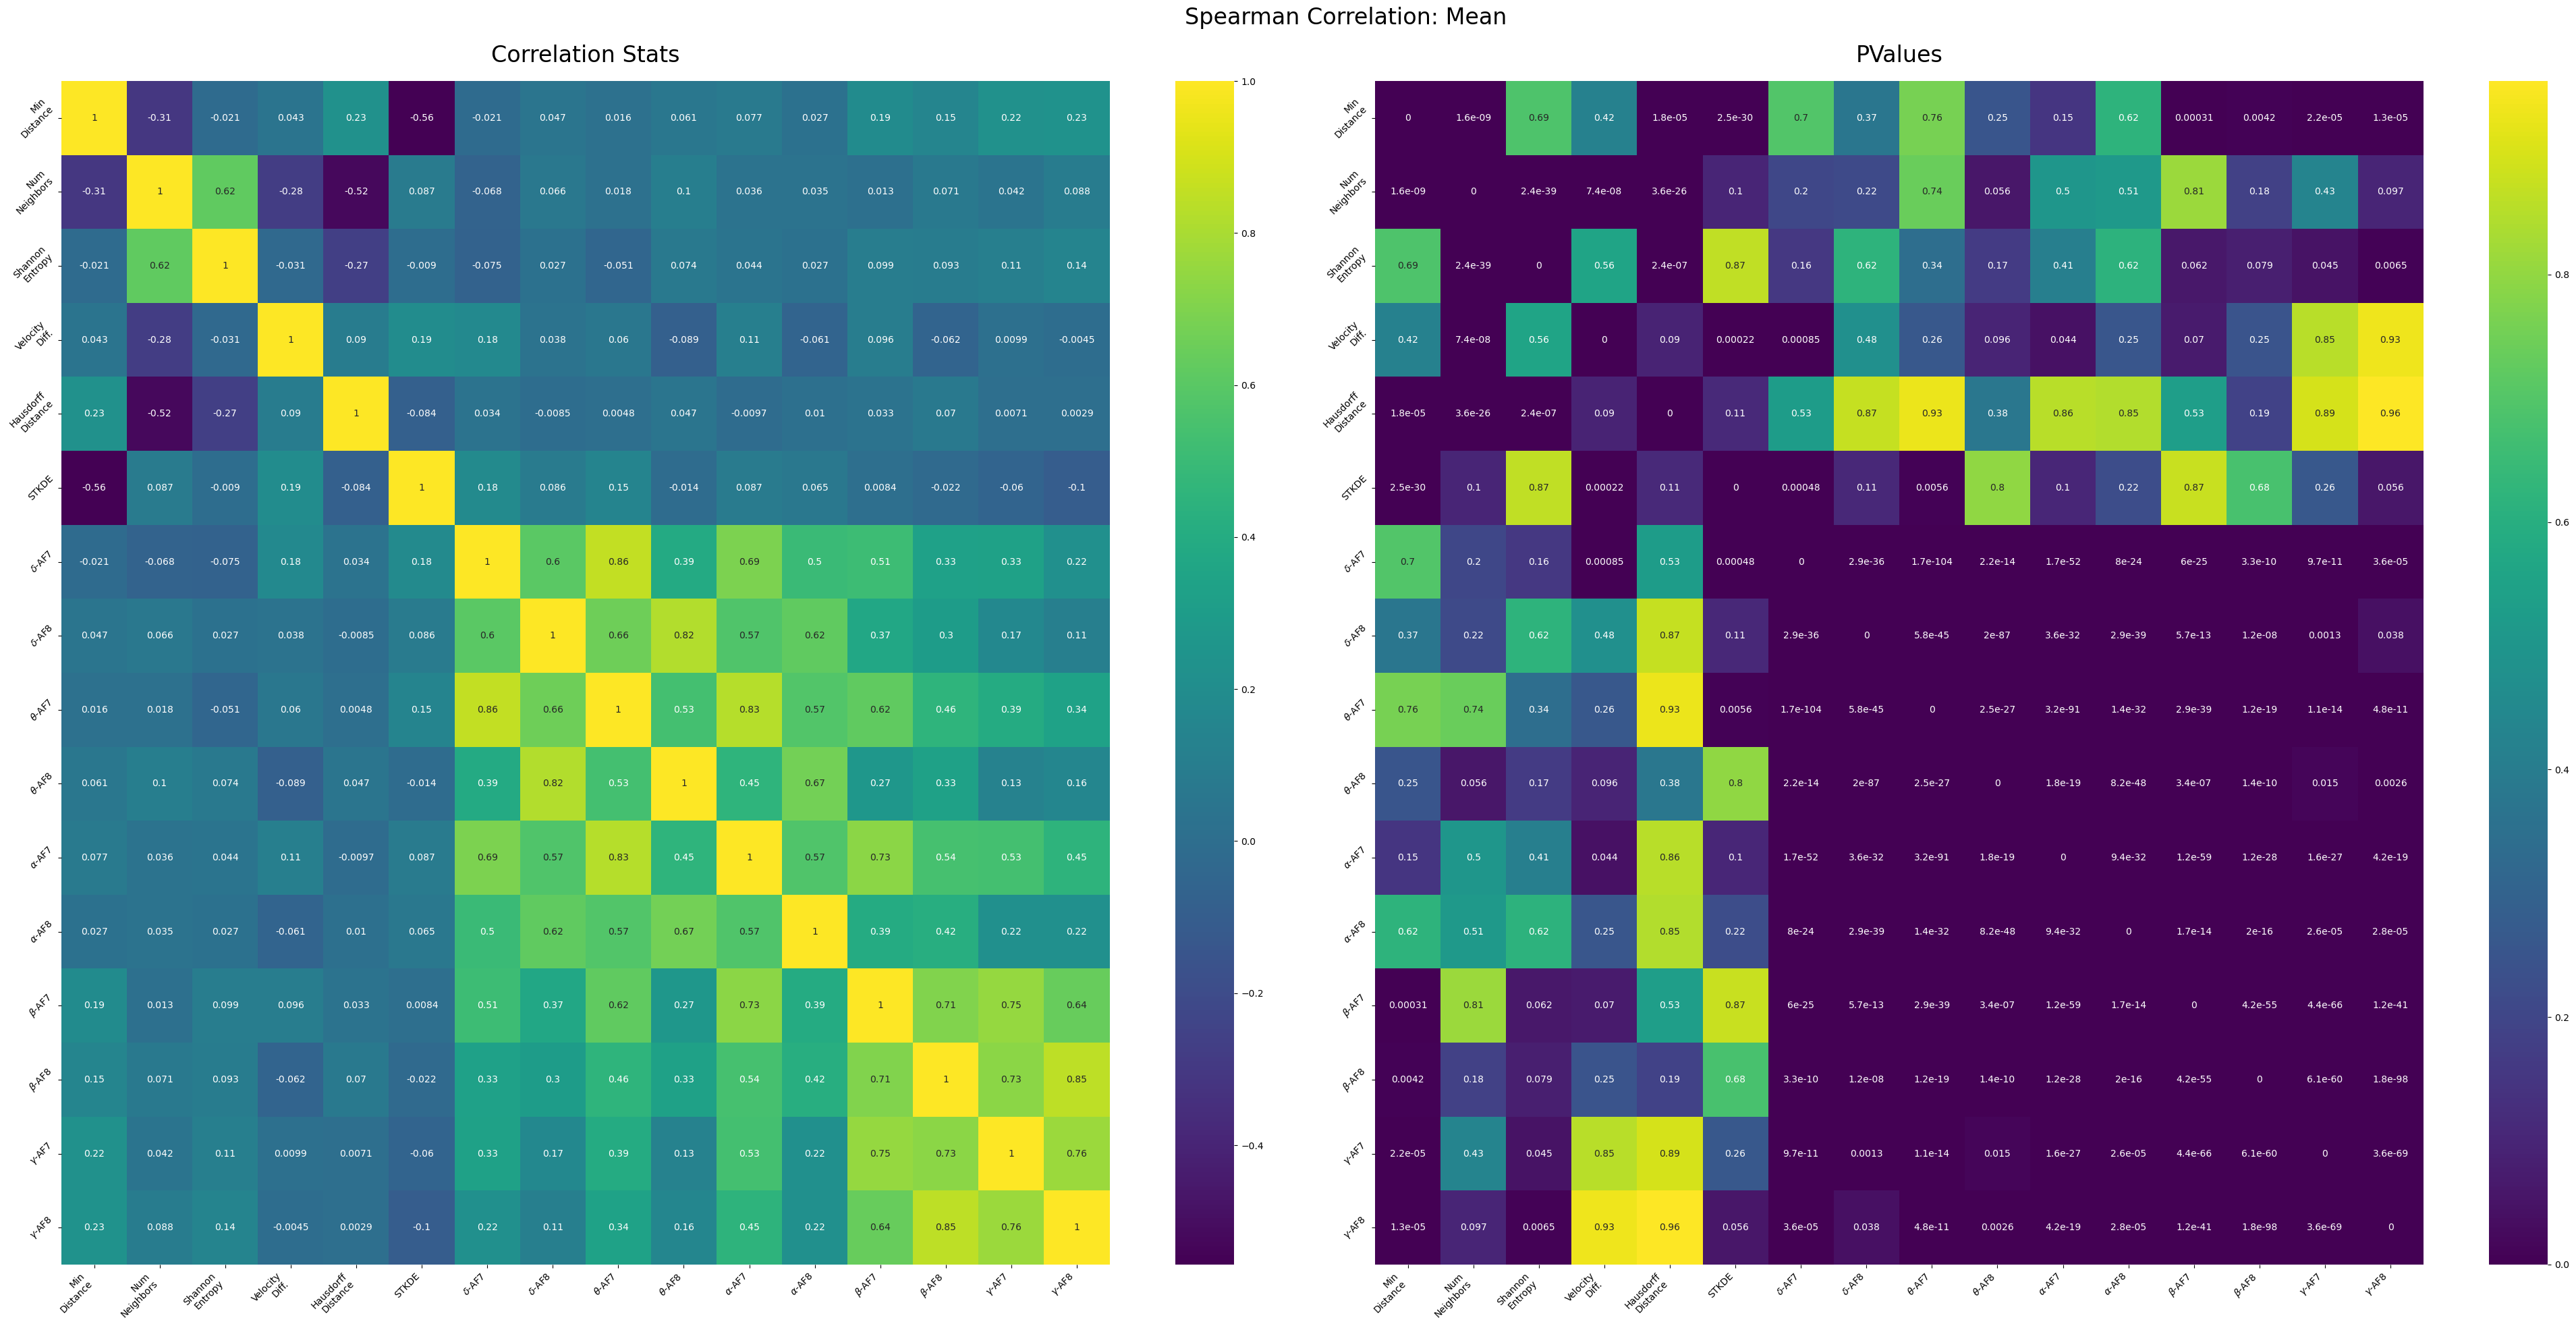

In [21]:
# correlation stats
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(40)
suptitle = fig.suptitle("Spearman Correlation: Mean")
suptitle.set(fontsize=24)

sns.heatmap(mean_s, 
    xticklabels=mean_s.columns.values, 
    yticklabels=mean_s.columns.values, 
    ax=axes[0],
    #cmap="YlGnBu",
    cmap='viridis',
    #cmap=cmap,
    annot=True)
axes[0].set_title('Correlation Stats', fontsize=24, pad=20)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=45, ha='right')

sns.heatmap(mean_p, 
    xticklabels=mean_p.columns.values, 
    yticklabels=mean_p.columns.values, 
    ax=axes[1],
    #cmap="YlGnBu",
    cmap='viridis',
    #cmap=cmap,
    annot=True)
axes[1].set_title('PValues', fontsize=24, pad=20)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.subplots_adjust(top=0.925)
plt.savefig(os.path.join(_OUTPUT_DIR, 'spearman_correlations'), bbox_inches='tight', pad_inches=0.1)

### 3.2.b Printing correlations via Latex

_These sets of functions can be used to print specific columns and rows. This is for Latex purposes._

In [19]:
# This is for printing columns where a cell is shaded if the P-value is smaller or equal to 0.05.
def print_latex_column(s, p, colname, rows, s_rounding=3, p_rounding=5):
    df2 = s[colname][rows]
    df3 = p[colname][rows]
    output_str = ''
    vals = list(zip(df2.values, df3.values))
    for val in vals:
        if val[1] <= 0.05:
            output_str += '\\shaded{$' + str(round(val[0],s_rounding)) + '$}\n\\shaded{$' + str(round(val[1],p_rounding)) + '$}\n'
        else:
            output_str += f'${round(val[0],s_rounding)}$ &\n${round(val[1],p_rounding)}$ &\n'
    print(output_str)

# This is fr printing columns where a cell is shaded if the value is greater than or equal to 0.5
def print_latex_column2(s, p, colname, rows, s_rounding=3, p_rounding=5):
    df2 = s[colname][rows]
    df3 = p[colname][rows]
    output_str_s = ''
    output_str_p = ''
    vals = list(zip(df2.values, df3.values))
    for val in vals:
        if val[0] >= 0.5:
            output_str_s += '& \\yshaded{$' + str(round(val[0],s_rounding)) + '$} '
            output_str_p += '& \\yshaded{$' + str(round(val[1],p_rounding)) + '$} '
        else:
            output_str_s += f'& ${round(val[0],s_rounding)}$ '
            output_str_p += f'& ${round(val[1],p_rounding)}$ '
    print(output_str_s)
    print()
    print(output_str_p)

In [20]:
print_cols = [r'$\delta$-AF7',r'$\delta$-AF8',r'$\theta$-AF7',r'$\theta$-AF8',r'$\alpha$-AF7',r'$\alpha$-AF8',r'$\beta$-AF7',r'$\beta$-AF8',r'$\gamma$-AF7',r'$\gamma$-AF8']
print_latex_column(mean_s, mean_p, r'$\gamma$-AF8', print_cols, p_rounding=200)

\shaded{$0.218$}
\shaded{$3.56836880183356e-05$}
\shaded{$0.11$}
\shaded{$0.03759408127273564$}
\shaded{$0.34$}
\shaded{$4.841078959292012e-11$}
\shaded{$0.16$}
\shaded{$0.0025595470133851555$}
\shaded{$0.45$}
\shaded{$4.2242447080741805e-19$}
\shaded{$0.22$}
\shaded{$2.849209628616451e-05$}
\shaded{$0.636$}
\shaded{$1.151874026810684e-41$}
\shaded{$0.846$}
\shaded{$1.7681196738931932e-98$}
\shaded{$0.764$}
\shaded{$3.566916582491862e-69$}
\shaded{$1.0$}
\shaded{$0.0$}



# 4. Displaying EEG

Consider these for printing figures for manuscripts and the like.

## 4.1 Raw EEG as Horizontal Plots

In [22]:
def PlotEEGHorizontal(df, frequencies, electrodes, colors, suptitle:str=None, save_figname:str=None):
    # Let's display this participant's EEG data
    
    for j in range(len(electrodes)):
        electrode = electrodes[j]
        
        fig, axes = plt.subplots(nrows=len(frequencies), ncols=1)
        fig.set_figheight(1.25*len(frequencies))
        fig.set_figwidth(15)
        print(len(axes))
        
        for i in range(len(frequencies)):
            color = colors[i]
            freq = frequencies[i]
            colname = f"{freq}_{electrode}_normalized"
            print(colname)
            ax = df.plot.line(x='trial_ms',y=colname, ax=axes[i], color=color)
            ax.legend_ = None
            
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], xlabel=None);
        plt.subplots_adjust(wspace=0, hspace=0)
        if save_figname: 
            plt.savefig(f'{save_figname}_{electrode}', bbox_inches="tight", pad_inches=0)
        plt.show()

5
Delta_AF7_normalized
Theta_AF7_normalized
Alpha_AF7_normalized
Beta_AF7_normalized
Gamma_AF7_normalized


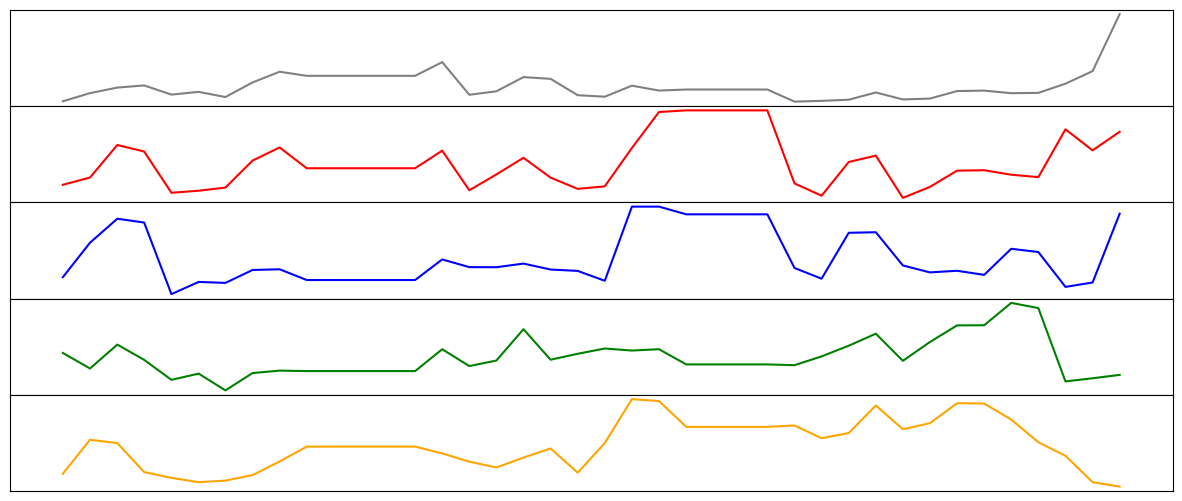

5
Delta_AF8_normalized
Theta_AF8_normalized
Alpha_AF8_normalized
Beta_AF8_normalized
Gamma_AF8_normalized


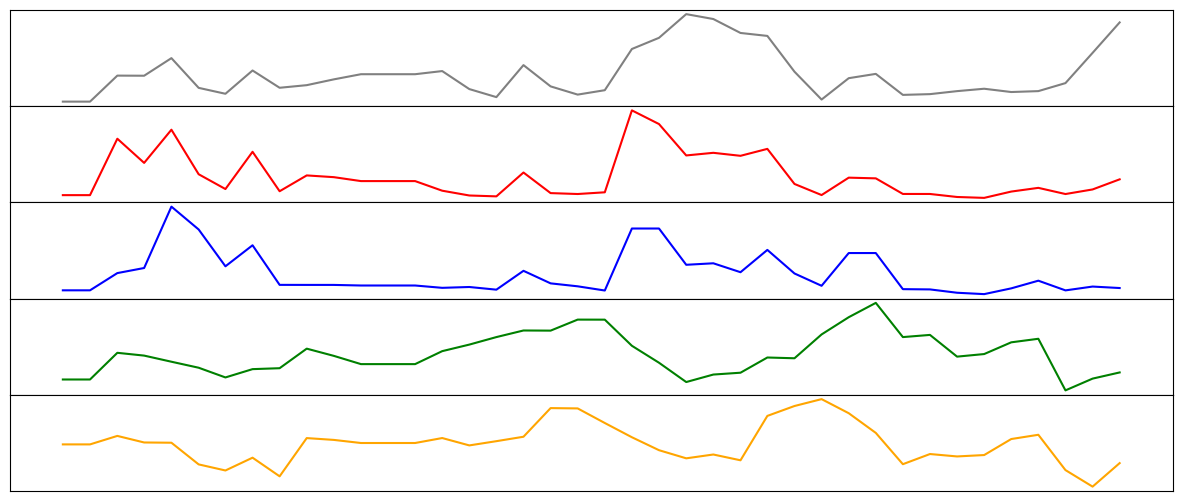

In [24]:
"""  ___________________________________  """
""" |TO-DOs:                            | """
""" | - Set the pid and tid of interest | """
"""   ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅  """
pid = 'p8'
tid = 'jay-vr-3'

td = pd.read_csv(os.path.join(_ALIGNED_DIR, pid, tid, 'trial.csv'))
s = td.iloc[-1]['unix_ms']
# Read the EEG data
eeg_ex = process_raw_eeg(os.path.join(_ALIGNED_DIR, pid, tid, 'raw_eeg.csv'))
e = eeg_ex['unix_ms'].iloc[-1] - 5000
eeg_ex = eeg_ex[eeg_ex['unix_ms'].between(s, e)]
eeg_ex['trial_ms'] = eeg_ex['unix_ms'] - s
        
# EEG Data Normalization
for freq in _FREQUENCY_BANDS:
    for electrode in _ELECTRODES:
        colname = f'{freq}_{electrode}'
        minV = gr_df[gr_df['participant']=='p8'].loc['min', in_colname]
        maxV = gr_df[gr_df['participant']=='p8'].loc['max', in_colname]
        eeg_ex[f'{colname}_normalized'] = (eeg_ex[colname] - minV) / (maxV - minV)

PlotEEGHorizontal(eeg_ex, _FREQUENCY_BANDS, _ELECTRODES, _FREQUENCY_COLORS, save_figname=os.path.join(_OUTPUT_DIR, f'{pid}-{tid}_eeg-hor'))

## 4.2 Displaying EEG + Velocity + Trajectories

Create a visualization that maps raw EEG to velocity data, all trajectory data

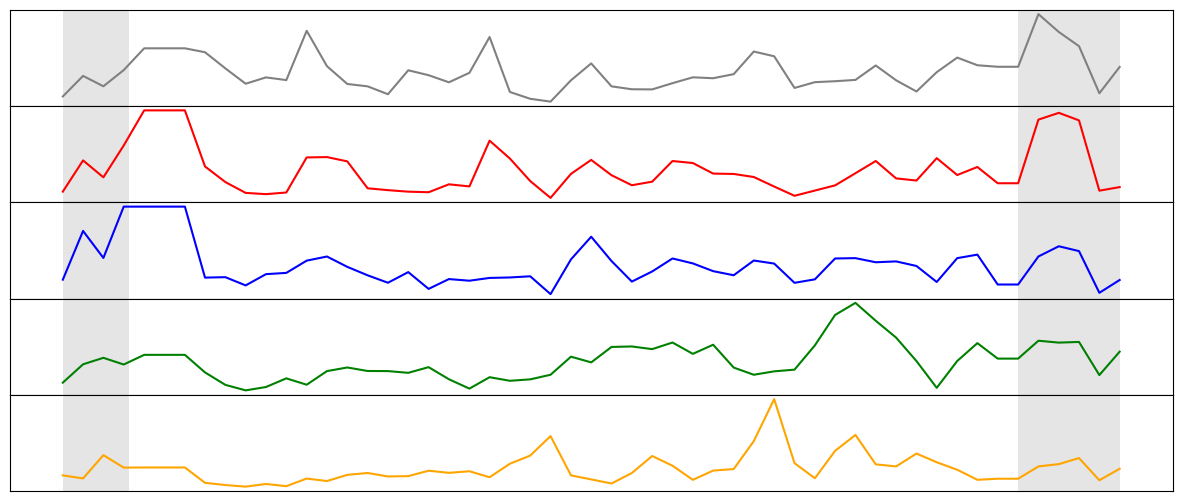

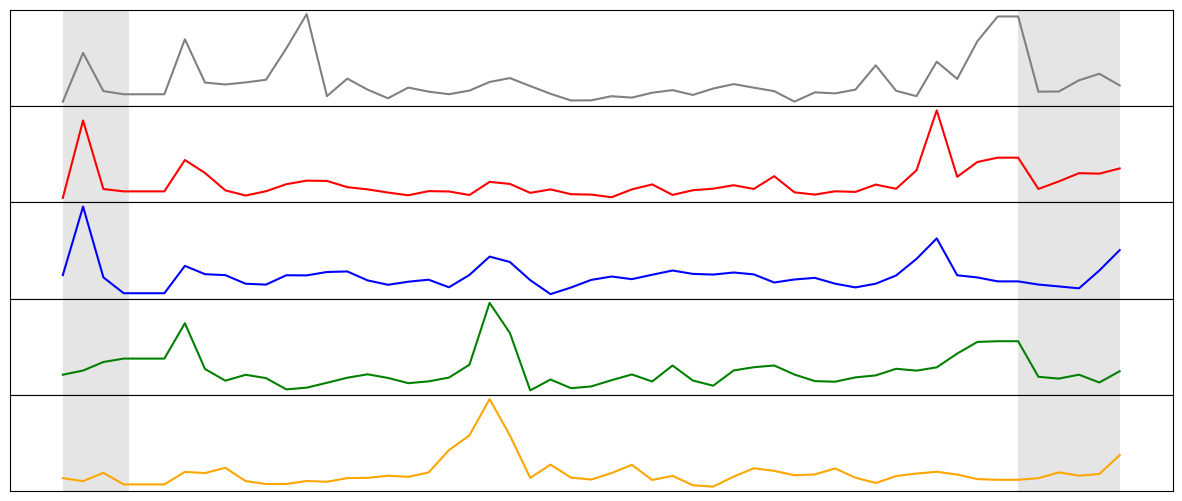

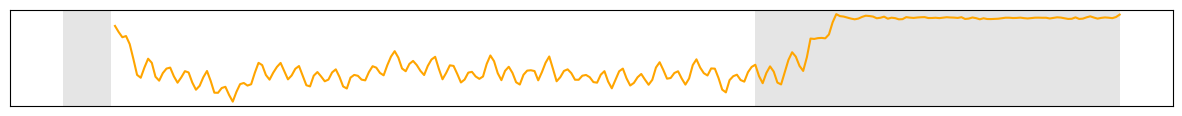

In [26]:
"""  ___________________________________  """
""" |TO-DOs:                            | """
""" | - Set the pid and tid of interest | """
"""   ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅  """
pid = 'p2'
tid = 'jay-vr-1'

# Get the directory based on the selecfed pid and tid
USER_EXAMPLE = os.path.join(_ALIGNED_DIR, pid, tid)

# Let's get the trial data
trial_df = pd.read_csv(os.path.join(USER_EXAMPLE, 'trial.csv'))
s = trial_df.iloc[-1]['unix_ms']

# Let's read raw eeg and normalize it. Also grab the end of the session too
eeg_ex = process_raw_eeg(os.path.join(USER_EXAMPLE, 'raw_eeg.csv'))
for freq in _FREQUENCY_BANDS:
    for electrode in _ELECTRODES:
        colname = f'{freq}_{electrode}'
        minV = gr_df[gr_df['participant']=='p2'].loc['min', in_colname]
        maxV = gr_df[gr_df['participant']=='p2'].loc['max', in_colname]
        eeg_ex[f'{colname}_normalized'] = (eeg_ex[colname] - minV) / (maxV - minV)
eeg_ex['trial_ms'] = eeg_ex['unix_ms'] - s
e = eeg_ex['trial_ms'].iloc[-1] - 5000

# Let's graph them together as an example. Let's make them share the same x-axis
for j in range(len(_ELECTRODES)):
    electrode = _ELECTRODES[j]
    fig, axes = plt.subplots(nrows=len(_FREQUENCY_BANDS), ncols=1)
    fig.set_figheight(1.25*len(_FREQUENCY_BANDS))
    fig.set_figwidth(15)
    for i in range(len(_FREQUENCY_BANDS)):
        color = _FREQUENCY_COLORS[i]
        freq = _FREQUENCY_BANDS[i]
        colname = f"{freq}_{electrode}_normalized"
        ax = eeg_ex.plot.line(x='trial_ms',y=colname, ax=axes[i], color=color)
        ax.legend_ = None
        ax.axvspan(xmin=eeg_ex.iloc[0]['trial_ms'], xmax=0, facecolor='grey', alpha=0.2)
        ax.axvspan(xmin=e, xmax=eeg_ex['trial_ms'].iloc[-1],facecolor='grey', alpha=0.2)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], xlabel=None);
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(os.path.join(_OUTPUT_DIR, f'eeg_example_{electrode}'), bbox_inches="tight", pad_inches=0)
    plt.show()

# Let's now read trajectory data of the participant
user_df = pd.read_csv(os.path.join(USER_EXAMPLE, 'user-aligned.csv'))
user_df = user_df.groupby(['pos_x','pos_y','pos_z'],as_index=False).first().sort_values(by=['trial_milliseconds'])
user_df = user_df.drop(columns=['pos_y','rel_pos_y','forward_y','rel_forward_y','velocity_y','rel_velocity_y'])
user_df = user_df.rename(columns={'trial_milliseconds':'trial_ms'})
user_df['trial_sec'] = user_df['trial_ms'] / 1000;
user_df['dt'] = user_df['trial_sec'].diff().fillna(0)
user_df['velocity'] = user_df['velocity_x'] + user_df['velocity_z']
player_df = Downsample(
    user_df, 
    ms_col='trial_ms', 
    val_cols={'velocity':'mean','velocity_x':'mean','velocity_z':'mean'},
    window_ms=250, slide_ms=250, 
    include_dt=True)
# Plot Downsampled Velocities
fig, ax = plt.subplots()
fig.set_figheight(1.25)
fig.set_figwidth(15)
ax = player_df.plot.line(x='trial_ms_end', y='velocity', ax=ax, color='orange')
ax.legend_ = None
ax.axvspan(xmin=eeg_ex.iloc[0]['trial_ms'], xmax=0, facecolor='grey', alpha=0.2)
ax.axvspan(xmin=e, xmax=player_df['trial_ms_end'].iloc[-1],facecolor='grey', alpha=0.2)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], xlabel=None)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(os.path.join(_OUTPUT_DIR, f'velocity_example'), bbox_inches="tight", pad_inches=0)
plt.show()

## 4.3 STKDE Plotting

Plot the KDE and STKDEs of specific participants' trials

In [27]:
"""  ___________________________________  """
""" |TO-DOs:                            | """
""" | - Set the pid and tid of interest | """
"""   ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅  """
pid = 'p2'
tid = 'jay-vr-1'

# Get the directory based on the selecfed pid and tid
KDE_EXAMPLE = os.path.join(_ALIGNED_DIR, pid, tid)

# Read position data of other agents. The data should already be aligned to match the trial data
# We separate this from the rest of the code here because of how lengthy this process can be.
agents_df = pd.read_csv(os.path.join(KDE_EXAMPLE, 'pedestrians-aligned.csv'))
agents_df = agents_df.drop(columns=['pos_y','rel_pos_y','forward_y','rel_forward_y','velocity_y','rel_velocity_y'])
agents_df = agents_df.rename(columns={'trial_milliseconds': 'trial_ms'})
agents_df['in_fustrum'] = abs(agents_df['angle_from_participant']) <= 55
agents_kde = STKDE(agents_df)

### 4.3.a KDE plots

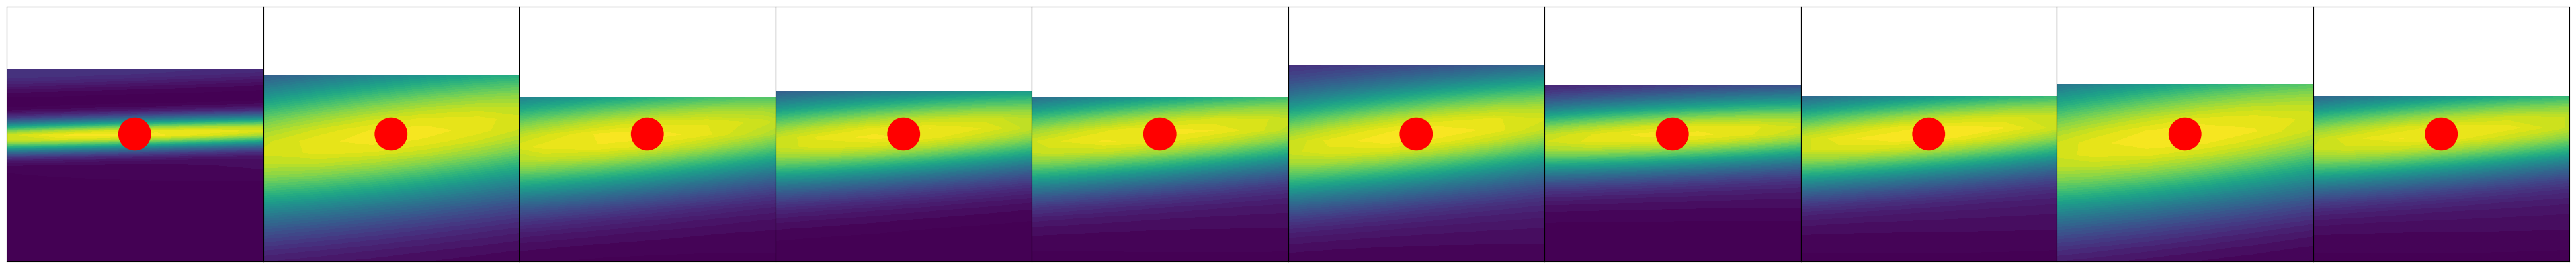

In [28]:
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

# calculate my own KDE and plot using plt.contourf
def make_kde(x, y):
    """
    Based on
    https://stackoverflow.com/questions/50917216/log-scales-with-seaborn-kdeplot
    """
    kde = gaussian_kde([x, y])
    xx, yy = np.mgrid[min(x):max(x):(max(x)-min(x))/100,
                      min(y):max(y):(max(y)-min(y))/100]
    density = kde(np.c_[xx.flat, yy.flat].T).reshape(xx.shape)    
    return xx, yy, density

# Get three random values in `tC`, use them to generate plot values
optimal_ts = []
unique_timestamps = agents_df['trial_ms'].unique().tolist()
rand_timestamps = random.sample(unique_timestamps, 10)
useful_ts = np.concatenate([optimal_ts, rand_timestamps], axis=None)

fig, axes = plt.subplots(figsize=(50, 5), ncols=10, nrows=1)

count = 0
for ts in useful_ts:
    rows = agents_df[agents_df['trial_ms'].between(ts-1000, ts+1000)]
    xgrid, ygrid, density = make_kde(rows['rel_pos_x'], rows['rel_pos_z'])
    ax = axes[count]
    ax.contourf(xgrid, ygrid, density, cmap="viridis", levels=50, extend="min")
    player_circle = plt.Circle((0, 0), .25, color='r')
    ax.add_patch(player_circle)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    count += 1

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], xlabel=None)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(os.path.join(_OUTPUT_DIR, 'kde_examples'), bbox_inches="tight", pad_inches=0)
plt.show()

### STKDE Plots

Note that we're choosing some specific timestamps

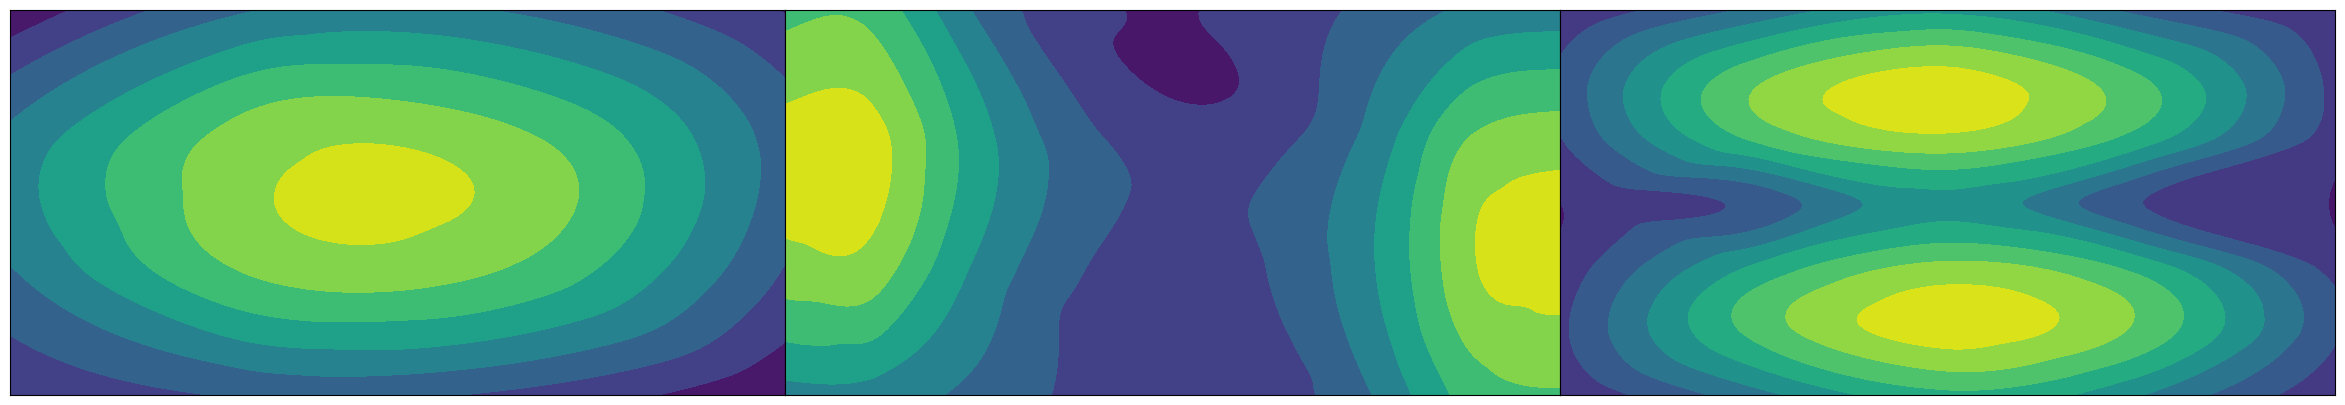

In [30]:
# Determine the three timestamps to use to generate plot values
optimal_ts = [16000, 18000, 24300]

fig, axes = plt.subplots(figsize=(30, 5), ncols=3, nrows=1)
count = 0
for ts in optimal_ts:
    ax = axes[count]
    df = agents_kde[agents_kde['tC'] == ts]
    
    grid_x, grid_y = np.meshgrid(
        np.linspace(df['xC'].min(), df['xC'].max(), 100),
        np.linspace(df['yC'].min(), df['yC'].max(), 100))
    
    # Interpolate values on the grid
    grid_z = griddata((df['xC'], df['yC']), df['density'], (grid_x, grid_y), method='cubic')

    # Set a default value for regions with no data (NaN values in grid_z)
    grid_z = np.nan_to_num(grid_z, nan=-1)  # -1 (or any value) will represent the empty space

    # Contour plot (using a color map)
    cp = ax.contourf(grid_x, grid_y, grid_z, cmap='viridis')
    #ax.set_xlim([-2, 2])
    #ax.set_ylim([-2, 2])
    count += 1

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[], xlabel=None)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(os.path.join(_OUTPUT_DIR, 'stkde_examples'), bbox_inches="tight", pad_inches=0)
plt.show()

## 4.4 EEG Freq. Power Plots

Bar charts for frequency powers. Note that the first, second, and third closest timestamps we'll be looking at are:

- first closest = 16024
- second closest = 18024
- third closest = 24024

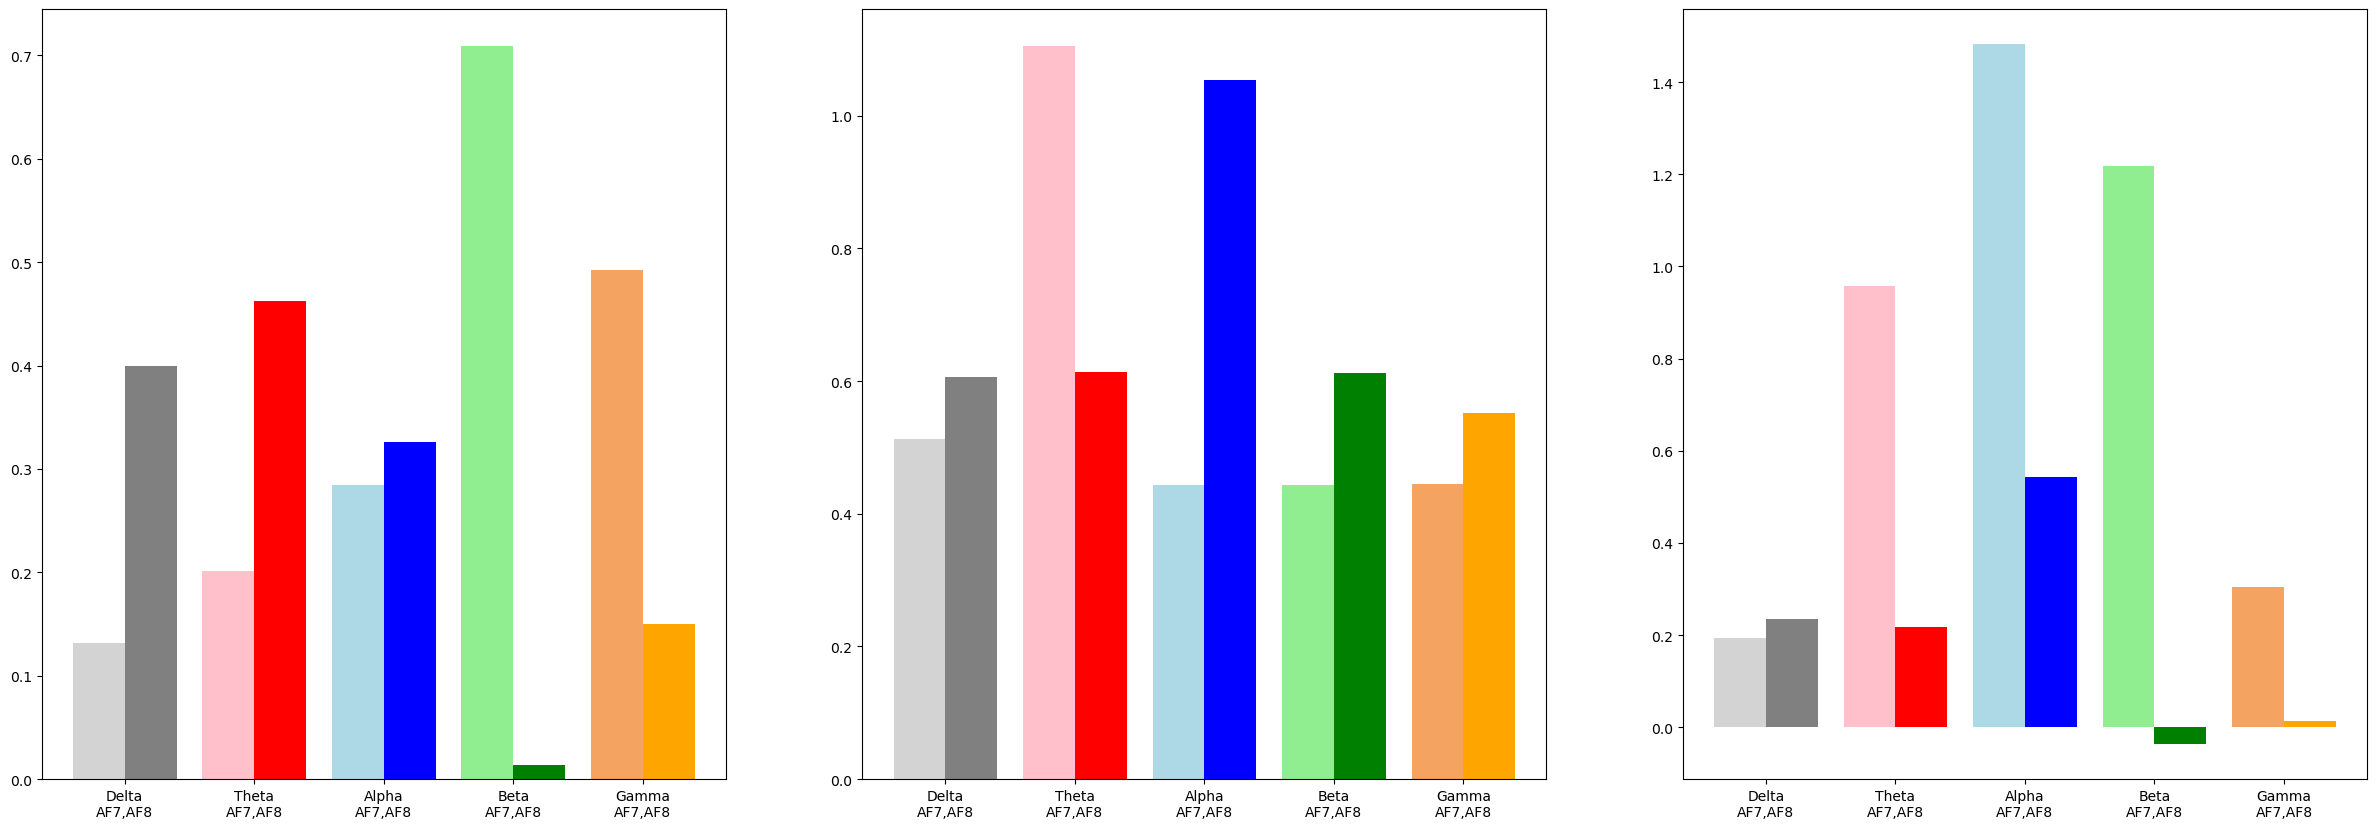

In [33]:
"""  ___________________________________  """
""" |TO-DOs:                            | """
""" | - Set the pid and tid of interest | """
"""   ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅ ̅  """
pid = 'p2'
tid = 'jay-vr-1'

example_means_df = gsamples_df[(gsamples_df['participant']==pid) & (gsamples_df['trial_id']==tid)]

num_groups = 5
group_width = 0.8 # Width of each bar
spacing = 1.0  # Space between groups
positions = num_groups * spacing

example_eeg_ts = [16024, 18024, 24024]
fig, axes = plt.subplots(figsize=(30,10), nrows=1, ncols=3)
count = 0
for ex_eeg_ts in example_eeg_ts:
    ts_df = example_means_df[example_means_df['trial_ms_end']==ex_eeg_ts]
    
    axes[count].bar(-group_width/4, ts_df['Delta_AF7'], width=group_width/2, label='Delta_AF7', color='lightgrey')
    axes[count].bar(group_width/4, ts_df['Delta_AF8'], width=group_width/2, label='Delta_AF8', color='grey')
    # 0.8 - 1.0 gap
    axes[count].bar(spacing - group_width/4, ts_df['Theta_AF7'], width=group_width/2, label='Theta_AF7', color='pink')
    axes[count].bar(spacing + group_width/4, ts_df['Theta_AF8'], width=group_width/2, label='Theta_AF8', color='red')
    # 1.8 - 2.0 gap
    axes[count].bar(2*spacing - group_width/4, ts_df['Alpha_AF7'], width=group_width/2, label='Alpha_AF7', color='lightblue')
    axes[count].bar(2*spacing + group_width/4, ts_df['Alpha_AF8'], width=group_width/2, label='Alpha_AF8', color='blue')
    # 2.8- 3.0 gap
    axes[count].bar(3*spacing - group_width/4, ts_df['Beta_AF7'], width=group_width/2, label='Beta_AF7', color='lightgreen')
    axes[count].bar(3*spacing + group_width/4, ts_df['Beta_AF8'], width=group_width/2, label='Beta_AF8', color='green')
    # 3.8 - 4.0 gap
    axes[count].bar(4*spacing - group_width/4, ts_df['Gamma_AF7'], width=group_width/2, label='Gamma_AF7', color='sandybrown')
    axes[count].bar(4*spacing + group_width/4, ts_df['Gamma_AF8'], width=group_width/2, label='Gamma_AF8', color='orange')

    axes[count].set_xticks(np.arange(num_groups))
    axes[count].set_xticklabels(['Delta\nAF7,AF8', 'Theta\nAF7,AF8', 'Alpha\nAF7,AF8', 'Beta\nAF7,AF8', 'Gamma\nAF7,AF8'])
    count += 1
    
plt.savefig(os.path.join(_OUTPUT_DIR, 'eeg_windows_examples'), bbox_inches="tight", pad_inches=0.2)
plt.show()